We shall start by importing the essential libraries.

In [1]:
### IMPORTING LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score, recall_score, roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter

Next, we clean the data and bring it to a form which will make the model building process easy. This phase is done exactly the same way as in 00 - Stroke EDA.

In [2]:
### DATA PREPARATION
stroke = pd.read_csv('C:\\Users\\Shekhar Lamba\\Documents\\Datasets\\healthcare-dataset-stroke-data.csv', na_values = [np.NaN, ' '])

df = pd.DataFrame(stroke)
df = df.drop(['id'], axis = 1)

num_vars = df.select_dtypes(include = ['int64', 'float64'])
cat_vars = df.select_dtypes(include = 'object')
feature_names = collections.defaultdict(str)
for name in num_vars.columns:
    feature_names[name]
for name in cat_vars.columns:
    feature_names[name]

mean_imputer = SimpleImputer(strategy = 'mean')
imputed_vars = mean_imputer.fit_transform(num_vars)
df_imputed = pd.DataFrame(np.hstack([imputed_vars, cat_vars]), columns = feature_names)

df_imputed['age'] = df_imputed['age'].astype('float64')
df_imputed['hypertension'] = df_imputed['hypertension'].astype('int64')
df_imputed['heart_disease'] = df_imputed['heart_disease'].astype('int64')
df_imputed['avg_glucose_level'] = df_imputed['avg_glucose_level'].astype('float64')
df_imputed['bmi'] = df_imputed['bmi'].astype('float64')
df_imputed['stroke'] = df_imputed['stroke'].astype('int64')

capping = num_vars.select_dtypes(include = 'float64')
for col in df_imputed.columns:
    if col in capping.columns:
        percentile = df_imputed[col].quantile([0.05, 0.95]).values
        df_imputed[col] = df_imputed[col].clip(lower = percentile[0], upper = percentile[1])
        
df_final = pd.get_dummies(df_imputed, columns = ['gender', 'ever_married', 'work_type', 'Residence_type',
                                              'smoking_status'], drop_first = True)

Now we separate the independent and dependent features; we label them X and y respectively. Then, we separate data for training and testing sets in the ratio of 8:2, making sure that the imbalance in the levels of the target variable, y, is maintained in both the sets. In other words, both the training and testing sets have the same proportion of people who did not suffer from stroke and those who did.

In [3]:
### SEPARATING TRAIN AND TEST SETS
X = df_final.drop(['stroke'], axis = 1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 99)

Before we build our Gradient Boosting model, remember that the data was highly unbalanced in that the number of people who did not suffer from stroke was far more than those who did. To overcome this problem, we shall perform oversampling using SMOTE technique which will produce new samples with their outcome as having stroke in order to make both the levels of y equal. SMOTE stands for Synthetic Minority Oversampling Technique and it uses the nearest neighbors of the minority class(having a stroke) to produce new and synthetic data points.

In [4]:
### OVERSAMPLING USING SMOTE
X_train_res, y_train_res = SMOTE(random_state = 99).fit_resample(X_train, y_train)
print(sorted(Counter(y_train_res).items()))

[(0, 3889), (1, 3889)]


We now go on to make a simple GBM model, which will serve as our baseline. We shall take 20% of the training data for validation and terminate training if the validation score doesnt improve for 10 iterations. We fit the model to the training data and plot the confusion matrix.

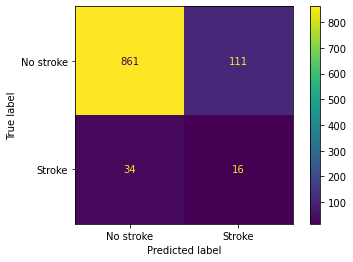

In [5]:
### CREATING A BASELINE MODEL
clf_gb = GradientBoostingClassifier(random_state = 99, validation_fraction = 0.3, n_iter_no_change = 10)
clf_gb.fit(X_train_res, y_train_res)
plot_confusion_matrix(clf_gb, X_test, y_test, display_labels = ['No stroke', 'Stroke'])

Before we proceed, let's take a look at the distribution of the levels of y in our dataset.

In [6]:
df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

Here, we see that around 95% of the people in our dataset have not suffered from stroke as opposed to just about 5% who actually have. This means that even if our model predicts every person as not having a stroke, the model will still be 95% accurate at the very least. So, in this case, accuracy is a deceptive metric. 


What we should rather be concerned with is the number of people who actually had stroke but were not identified by the model as having stroke i.e. the False Negatives. Lower the FN value, lower is the risk of overlooking a possible case of stroke and thus better is the model because the main objective of the model here should be to possibly save lives by correctly identifying a stroke case as early as possible. To reduce the FN value, we need to ensure that the recall of stroke cases is high since recall and FN are inversely proportional.


So, we shall calculate the accuracy and recall values for the predictions made by the model.

In [7]:
### CALCULATING ESSENTIAL METRICS
y_pred_gb = clf_gb.predict(X_test)
print(classification_report(y_test, y_pred_gb, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_gb))
print('Recall score: %f' % recall_score(y_test, y_pred_gb))

              precision    recall  f1-score   support

   No stroke       0.96      0.89      0.92       972
      Stroke       0.13      0.32      0.18        50

    accuracy                           0.86      1022
   macro avg       0.54      0.60      0.55      1022
weighted avg       0.92      0.86      0.89      1022

Accuracy: 0.858121
Recall score: 0.320000


If we look at the confusion matrix, we see that out of the 50 cases that had actually suffered from stroke, only 16 were correctly predicted as having a stroke by our model while the remaining 34 were overlooked. This gives us a recall score of 32% while the accuracy is about 86%. So, we can right away say that the baseline model is a poor one. 

Next, we plot the ROC curve and calculate the AUC score.

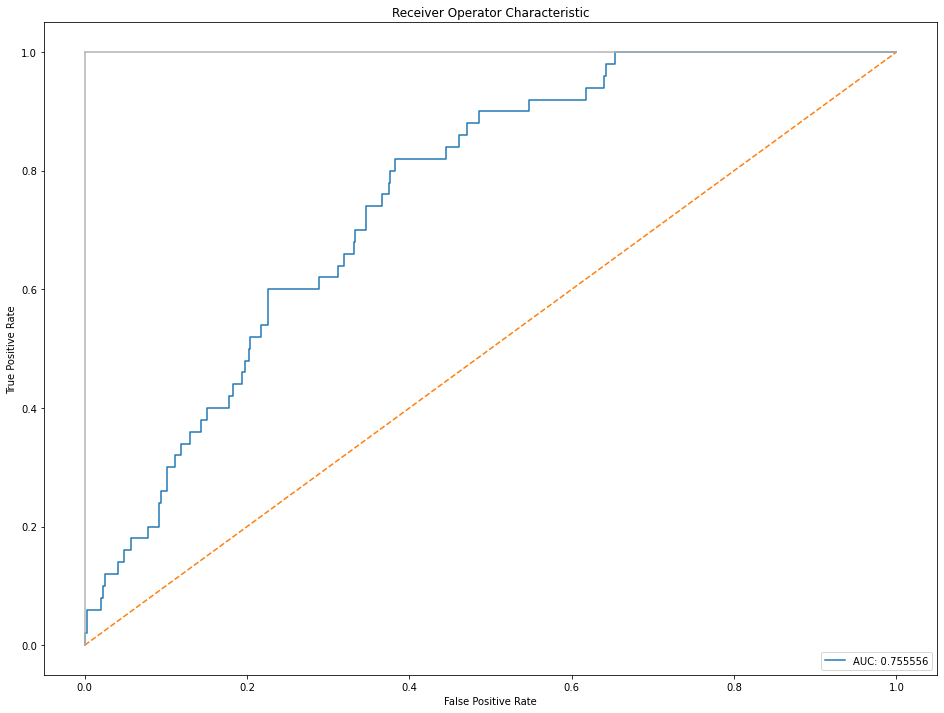

In [8]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_gb = clf_gb.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_gb)
roc_auc = roc_auc_score(y_test, y_prob_gb)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.7556.


Next, we will try to improve the model by tuning it's hyperparameters. For this, we shall use a random search with 5 fold cross-validation across the possible values for the following hyperparameters:
1. n_estimators: the total number of learners(trees in this case) to be considered 
2. max_depth: the maximum number of levels in each tree 
3. max_features: the maximum number of features to be considered while making each tree
4. min_samples_leaf: the minimum number of samples required to consider a node as a leaf
5. min_samples_split: the minimum number of samples required to further split a node 
6. learning_rate: it reduces the effect of individual trees thereby decreasing overfitting
7. subsample: percent of the total samples to be considered while building each tree

As we are trying to decrease the FN value, we will use roc_auc as our scoring parameter. Also, since we are using GBM, number of iterations should be low to prevent overfitting.

In [9]:
### TUNING HYPERPARAMETER VALUES USING RANDOMIZED SEARCH
param_distributions_1 = {
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(3, 10),
    'max_features': range(3, 10),
    'min_samples_split': range(10, 500, 20),
    'min_samples_leaf': range(10, 500, 20),
    'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'subsample': [i/100 for i in range(60, 85, 5)]
}
gb = GradientBoostingClassifier(random_state = 99, validation_fraction = 0.3, n_iter_no_change = 1)
random_fit_1 = RandomizedSearchCV(estimator = gb,
                                 param_distributions = param_distributions_1,
                                 scoring = 'roc_auc',
                                 n_iter = 2,
                                 cv = 5,
                                 random_state = 99,
                                 verbose = 2,
                                 n_jobs = -1)
random_fit_1.fit(X_train_res, y_train_res)
print(random_fit_1.best_params_)
print('Best score: %f' % random_fit_1.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.1s finished


{'subsample': 0.8, 'n_estimators': 600, 'min_samples_split': 330, 'min_samples_leaf': 310, 'max_features': 8, 'max_depth': 4, 'learning_rate': 0.0005}
Best score: 0.909900


Now, with these tuned hyperparameter values, we shall create our final Gradient Boosting model.

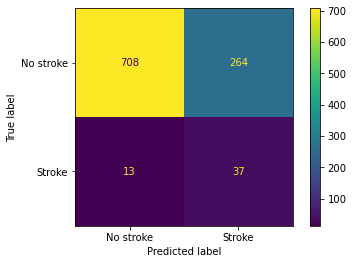

In [10]:
### CREATING THE FINAL MODEL
clf_gb = GradientBoostingClassifier(random_state = 99,
                                   n_estimators = 600,
                                   max_depth = 4,
                                   max_features = 8,
                                   min_samples_split = 330,
                                   min_samples_leaf = 310,
                                   learning_rate = 0.0005,
                                   subsample = 0.8,
                                   validation_fraction = 0.3,
                                   n_iter_no_change = 10)
clf_gb.fit(X_train_res, y_train_res)
plot_confusion_matrix(clf_gb, X_test, y_test, display_labels = ['No stroke', 'Stroke'])

Of the 50 stroke cases, the final model predicts 37 correctly while it fails to do the same for the other 13. This is better than our baseline model.

In [11]:
### CALCULATING ESSENTIAL METRICS
y_pred_gb = clf_gb.predict(X_test)
print(classification_report(y_test, y_pred_gb, target_names = ['No stroke', 'Stroke']))
print('Accuracy: %f' % accuracy_score(y_test, y_pred_gb))
print('Recall score: %f' % recall_score(y_test, y_pred_gb))

              precision    recall  f1-score   support

   No stroke       0.98      0.73      0.84       972
      Stroke       0.12      0.74      0.21        50

    accuracy                           0.73      1022
   macro avg       0.55      0.73      0.52      1022
weighted avg       0.94      0.73      0.81      1022

Accuracy: 0.728963
Recall score: 0.740000


The recall score gone up to 74% while the accuracy has reduced to about 73%, pointing to the already established fact that accuracy is a deceptive metric in this case.

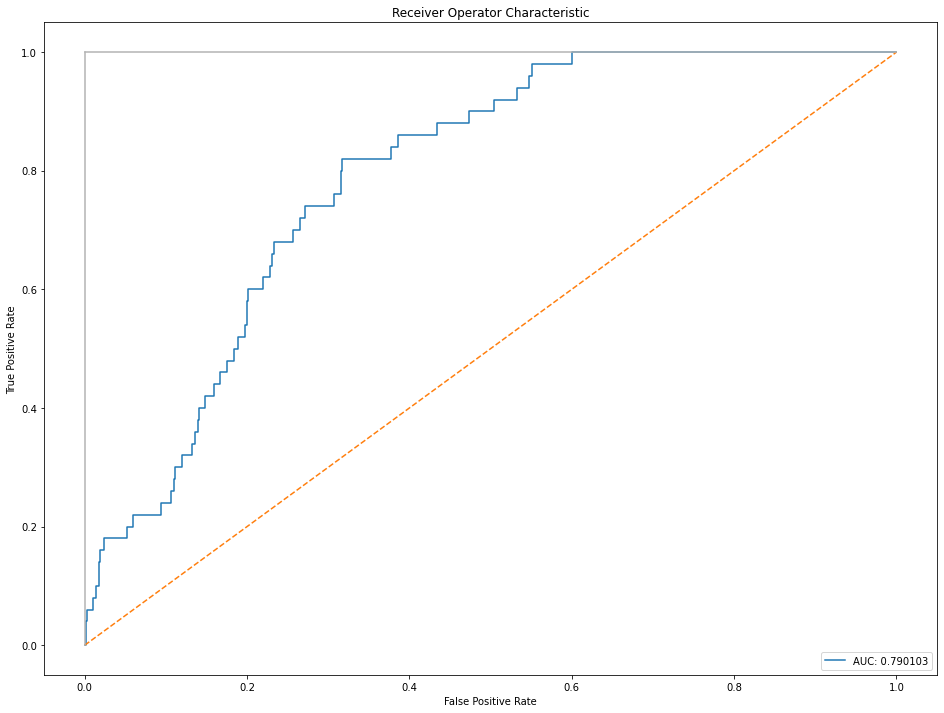

In [12]:
### PLOTTING ROC CURVE WITH AUC VALUE
y_prob_gb = clf_gb.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_prob_gb)
roc_auc = roc_auc_score(y_test, y_prob_gb)
plt.figure(figsize = (16, 12))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, label = 'AUC: %f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0], c = '0.7')
plt.plot([1, 1], c = '0.7')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

We get an AUC score of about 0.79 which is more than it's predecessor. This further proves our case for the final model being than the baseline model.